# 2. Shift Analysis

In [1]:
import json
import requests
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx
import collections as col
import patchwork

In [2]:
response = requests.get("https://gitlab.com/drvicsana/cop-proyecto-2023/-/raw/main/project_data/incidentes2019.json")
incidents_db = json.loads(response.text)
response = requests.get("https://gitlab.com/drvicsana/cop-proyecto-2023/-/raw/main/project_data/barrios.json")
ntas_db = json.loads(response.text)

incidents = pd.DataFrame.from_dict(incidents_db)
barrios = pd.DataFrame.from_dict(ntas_db)

In [3]:
# We calculate the number of vehicles used of each type for each incident
incidents = pd.DataFrame.from_dict(incidents_db)
incidents["n_vehicles"] = [len(incidents.units[i]) for i in range(incidents.shape[0])]
incidents["n_ladder"] = [incidents.units[i].count("ladder") for i in range(incidents.shape[0])]
incidents["n_engine"] = [incidents.units[i].count("engine") for i in range(incidents.shape[0])]
incidents["n_squad"] = [incidents.units[i].count("squad") for i in range(incidents.shape[0])]
incidents["n_rescue"] = [incidents.units[i].count("rescue") for i in range(incidents.shape[0])]
incidents["n_hazmat"] = [incidents.units[i].count("hazardous") for i in range(incidents.shape[0])]
incidents["incident_duration"] = incidents["incident_duration"].astype("int64", errors='ignore')
d_vehicles = {}
for i in incidents["nta"].unique():
    ladder = incidents["n_ladder"][incidents["nta"]==i].sum()
    engine = incidents["n_engine"][incidents["nta"]==i].sum()
    squad = incidents["n_squad"][incidents["nta"]==i].sum()
    rescue = incidents["n_rescue"][incidents["nta"]==i].sum()
    hazmat = incidents["n_hazmat"][incidents["nta"]==i].sum()
    d_vehicles[i] = [ladder, engine, squad, rescue, hazmat]

In [4]:
dic = {} # For each vehicle, it associates the number of units per number of times
for x in ["n_engine","n_ladder","n_squad","n_rescue","n_hazmat"]:
    dic[x] = col.Counter(incidents["n_engine"])
df = pd.merge(incidents, barrios)

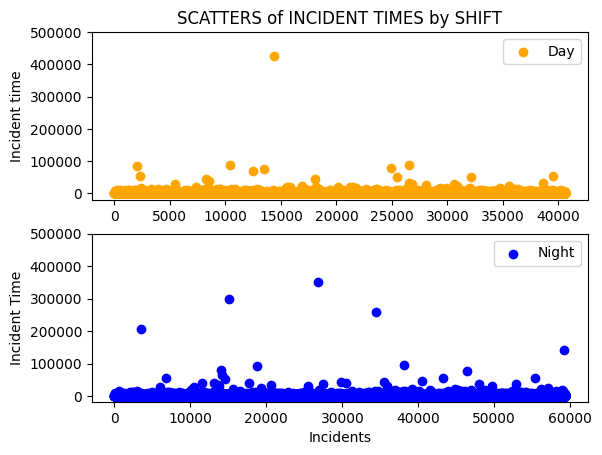

In [5]:
##############################################
### Scatter plot Incidents by shift ###
##############################################

plt.figure()
plt.title("SCATTERS of INCIDENT TIMES by SHIFT")
plt.axis("off")

plt.subplot(2,1,1)
plt.scatter(range(100000-59365),df["incident_duration"][df["is_first_shift"]==False].values, label="Day", color='orange')   
plt.yticks([0,100000,200000,300000,400000,500000])
plt.ylabel("Incident time")
plt.legend(loc="best")

plt.subplot(2,1,2)
plt.scatter(range(59365),df["incident_duration"][df["is_first_shift"]==True].values, label="Night", color='blue')   
plt.yticks([0,100000,200000,300000,400000, 500000])
plt.ylabel("Incident Time")
plt.xlabel("Incidents")
plt.legend(loc="best")
plt.show()

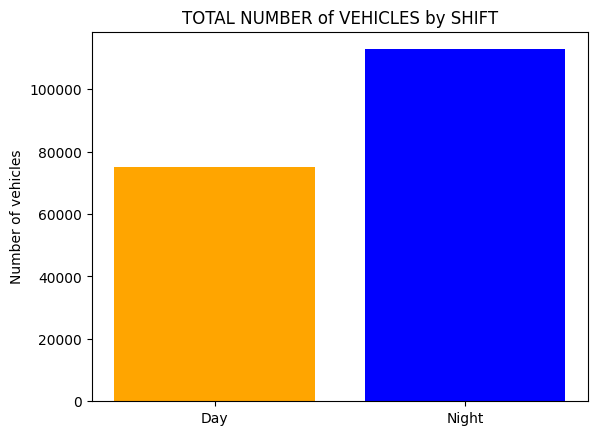

In [6]:
##############################################
### Bar plot number of vehicles by shift ###
##############################################
plt.figure()
v_day = sum(df["n_vehicles"][df["is_first_shift"]==False])
plt.bar(["Day", "Night"],[v_day, sum(df["n_vehicles"])-v_day], color = ["orange", "blue"])
plt.title("TOTAL NUMBER of VEHICLES by SHIFT")
plt.ylabel("Number of vehicles")
plt.show()

In [7]:
ratio_day = v_day/len(df[df["is_first_shift"]==False])
ratio_night = sum(df["n_vehicles"][df["is_first_shift"]==True])/len(df[df["is_first_shift"]==True])
print(f"The ratio Vehicles/Incidents during the DAY is: {ratio_day:.3f}")
print(f"The ratio Vehicles/Incidents during the NIGHT is: {ratio_night:.3f}")

The ratio Vehicles/Incidents during the DAY is: 1.845
The ratio Vehicles/Incidents during the NIGHT is: 1.899


In [8]:
# Here we calculate the number of incidents by shift for each district
distrits = df["boro_name"].unique()
dic2 = {}
for i in distrits:
    v = sum(df["n_vehicles"][df["is_first_shift"]==False][df["boro_name"]==i])
    incids = len(df[df["boro_name"]==i][df["is_first_shift"]==False])
    day = (v, incids)
    v = sum(df["n_vehicles"][df["is_first_shift"]==True][df["boro_name"]==i])
    incids = len(df[df["boro_name"]==i][df["is_first_shift"]==True])
    night = (v, incids)
    dic2[i]= {"Day":day, "Night":night}
dic2

C:\Users\samue\AppData\Local\Temp\ipykernel_14068\592397898.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  incids = len(df[df["boro_name"]==i][df["is_first_shift"]==False])
C:\Users\samue\AppData\Local\Temp\ipykernel_14068\592397898.py:9: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  incids = len(df[df["boro_name"]==i][df["is_first_shift"]==True])
C:\Users\samue\AppData\Local\Temp\ipykernel_14068\592397898.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  incids = len(df[df["boro_name"]==i][df["is_first_shift"]==False])
C:\Users\samue\AppData\Local\Temp\ipykernel_14068\592397898.py:9: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  incids = len(df[df["boro_name"]==i][df["is_first_shift"]==True])
C:\Users\samue\AppData\Local\Temp\ipykernel_14068\592397898.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  incids = len(df[df

{'Manhattan': {'Day': (26361, 14316), 'Night': (16767, 8858)},
 'Bronx': {'Day': (11516, 6148), 'Night': (17237, 8971)},
 'Brooklyn': {'Day': (15028, 8174), 'Night': (39463, 20763)},
 'Queens': {'Day': (14754, 8071), 'Night': (27953, 14755)},
 'Staten Island': {'Day': (7297, 3926), 'Night': (11328, 6018)}}

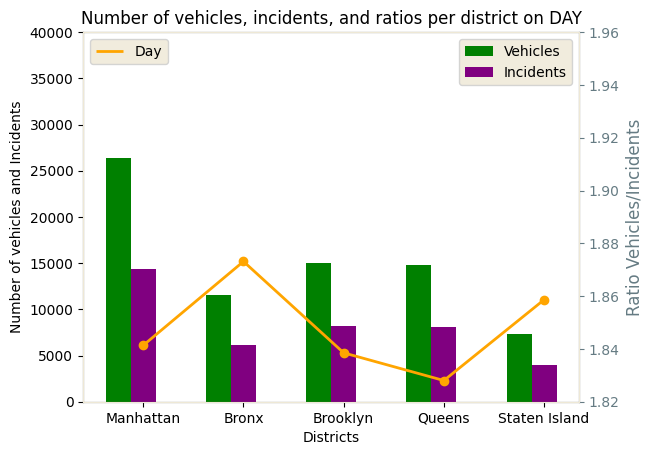

In [9]:
##############################################
### Bar plot number of incidents and vehicles, and V/I ratio by district on DAY ###
##############################################
n = len(distrits)
x = np.arange(n)
vy = [v["Day"][0] for i,v in dic2.items()]
iy = [v["Day"][1] for i,v in dic2.items()]
r = [a/b for a,b in zip(vy, iy)]
width = 0.25

fig, axes = plt.subplots()
plt.title("Number of vehicles, incidents, and ratios per district on DAY")
plt.style.use('Solarize_Light2')
plt.bar(x - width, vy, width=width, label='Vehicles', color="green")
plt.bar(x, iy, width=width, label='Incidents', color="purple")
plt.xticks(x, distrits)
plt.yticks([0,5000,10000,15000,20000,25000,30000,35000,40000])
plt.legend(loc='best')
plt.ylabel("Number of vehicles and Incidents")
plt.xlabel("Districts")

twin_axes = axes.twinx() 
twin_axes.plot(x, r, color="orange", label="Day")
twin_axes.scatter(x, r, color="orange")
plt.yticks([1.82+0.02*i for i in range(8)])
twin_axes.yaxis.grid()
twin_axes.set_ylabel("Ratio Vehicles/Incidents")
twin_axes.legend(loc='upper left')
plt.show()

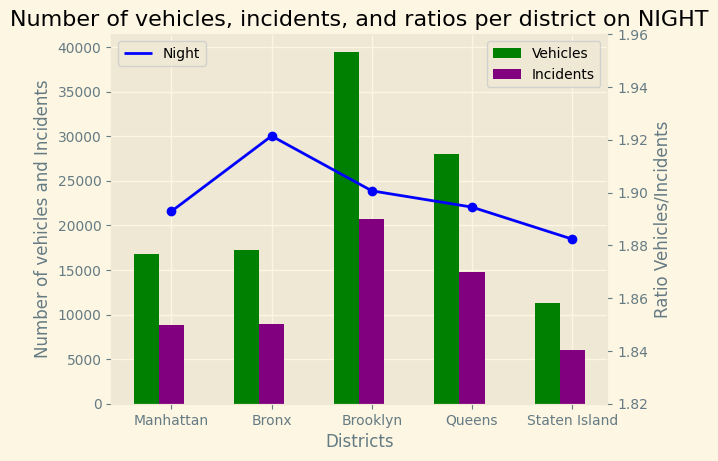

In [10]:
##############################################
### Bar plot number of incidents and vehicles, and V/I ratio by district on NIGHT ###
##############################################
n = len(distrits)
x = np.arange(n)
vy = [v["Night"][0] for i,v in dic2.items()]
iy = [v["Night"][1] for i,v in dic2.items()]
r = [a/b for a,b in zip(vy, iy)]
width = 0.25

fig, axes = plt.subplots()
plt.title("Number of vehicles, incidents, and ratios per district on NIGHT")
plt.style.use('Solarize_Light2')
plt.bar(x - width, vy, width=width, label='Vehicles', color="green")
plt.bar(x, iy, width=width, label='Incidents', color="purple")
plt.xticks(x, distrits)
plt.yticks([0,5000,10000,15000,20000,25000,30000,35000,40000])
plt.legend(loc='best')
plt.ylabel("Number of vehicles and Incidents")
plt.xlabel("Districts")

twin_axes = axes.twinx() 
twin_axes.plot(x, r, color="blue", label="Night")
twin_axes.scatter(x, r, color="blue")
plt.yticks([1.82+0.02*i for i in range(8)])
twin_axes.yaxis.grid()
twin_axes.set_ylabel("Ratio Vehicles/Incidents")
twin_axes.legend(loc='upper left')
plt.show()

In [11]:
#Here we see if there are differences in the most used vehicle types between day and night
#We calculate the % of vehicles used for each type between the total number of uses of each type
dic3 = {}
for i in ["n_ladder", "n_engine", "n_squad", "n_rescue", "n_hazmat"]:
    day = sum(df[i][df["is_first_shift"]==False])
    night = sum(df[i][df["is_first_shift"]==True])
    suma = sum((day,night))
    try:
        dic3[i] = [day/suma, night/suma]
    except ZeroDivisionError:
        dic3[i] = [0,0]
total_day = sum(df["n_vehicles"][df["is_first_shift"]==False])
total_night = sum(df["n_vehicles"][df["is_first_shift"]==True])
total = total_day + total_night
dic3["Total"] = [total_day/total, total_night/total]
dic3

{'n_ladder': [0.38717943126308446, 0.6128205687369156],
 'n_engine': [0.431181250679192, 0.568818749320808],
 'n_squad': [0.16029207232267037, 0.8397079276773296],
 'n_rescue': [0.16837637071100106, 0.8316236292889989],
 'n_hazmat': [0.5005384449709239, 0.499461555029076],
 'Total': [0.3993308613561778, 0.6006691386438222]}

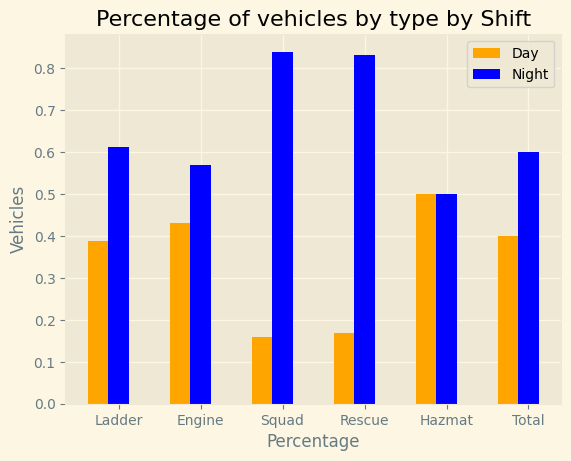

In [12]:
##############################################
### Bar plot of % by type and the total ###
##############################################
vehicles = ["Ladder", "Engine", "Squad", "Rescue", "Hazmat", "Total"]
n = len(vehicles)
x = np.arange(n)
vy = [v[0] for i,v in dic3.items()]
iy = [v[1] for i,v in dic3.items()]
width = 0.25

plt.title("Percentage of vehicles by type by Shift")
plt.style.use('Solarize_Light2')
plt.bar(x - width, vy, width=width, label='Day', color="orange")
plt.bar(x, iy, width=width, label='Night', color="blue")
plt.xticks(x, vehicles)
plt.legend(loc='best')
plt.xlabel("Percentage")
plt.ylabel("Vehicles")
plt.show()